Mounted at /content/drive


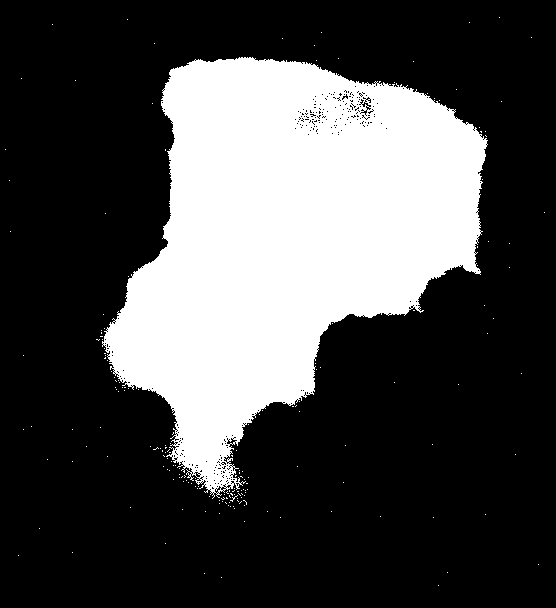

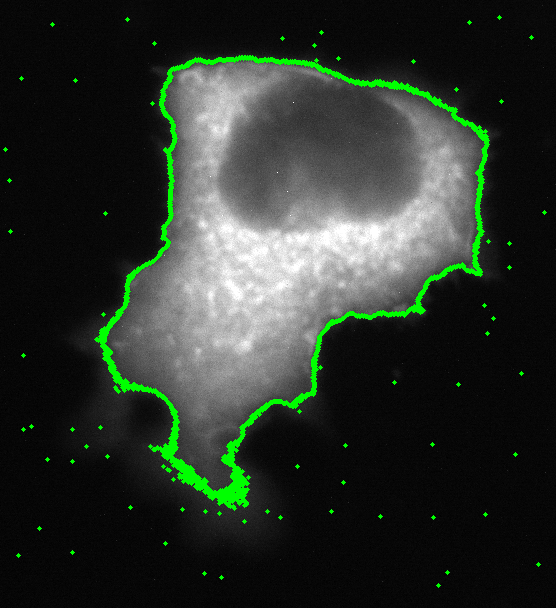

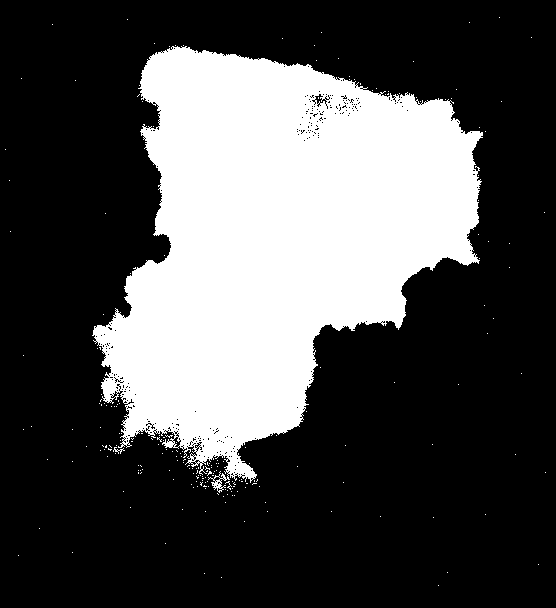

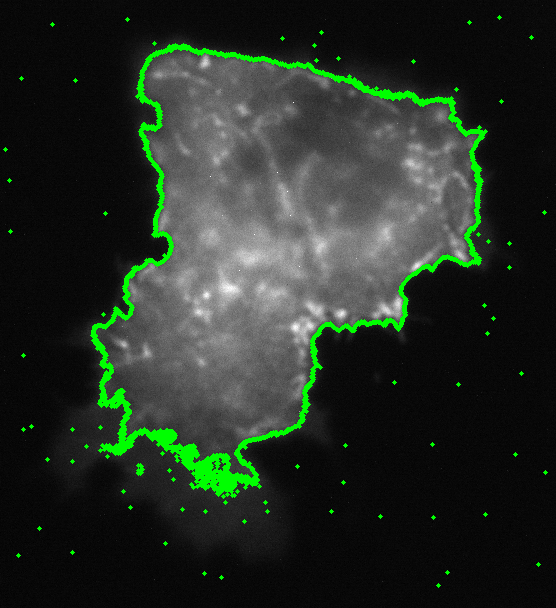

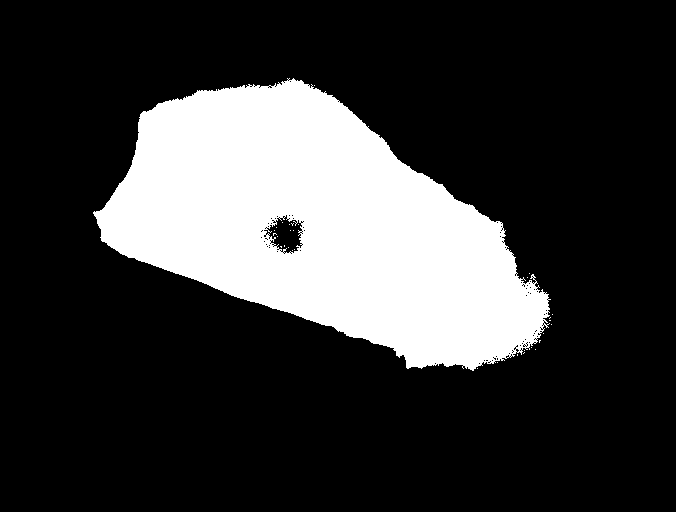

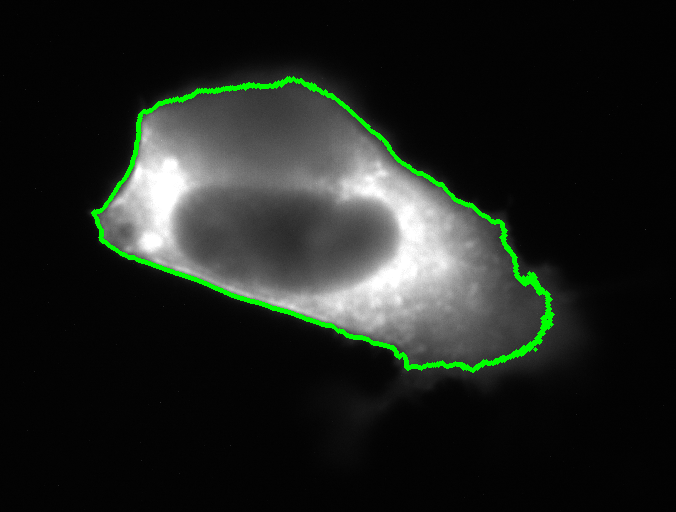

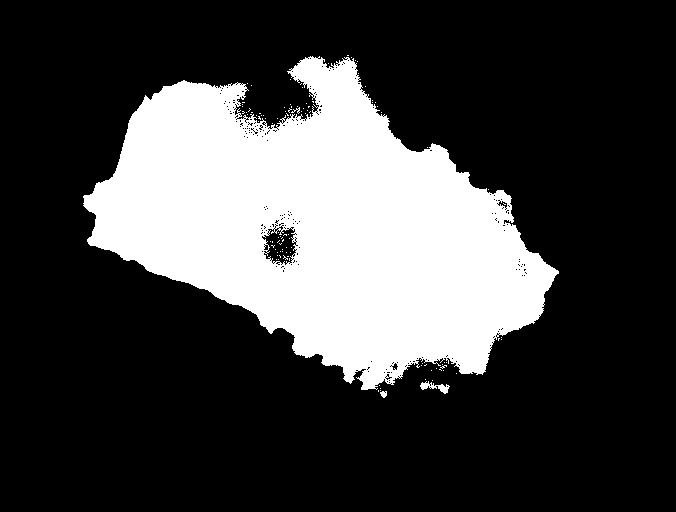

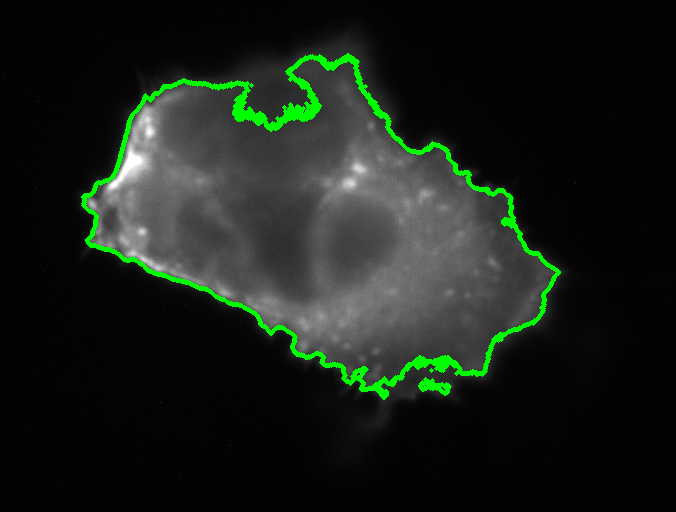

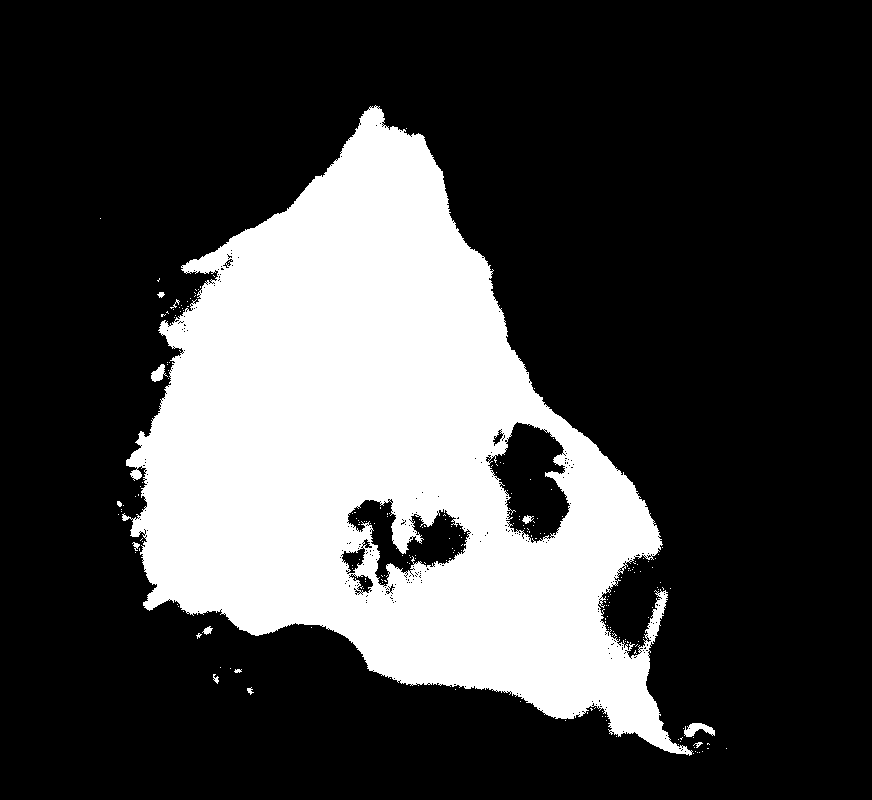

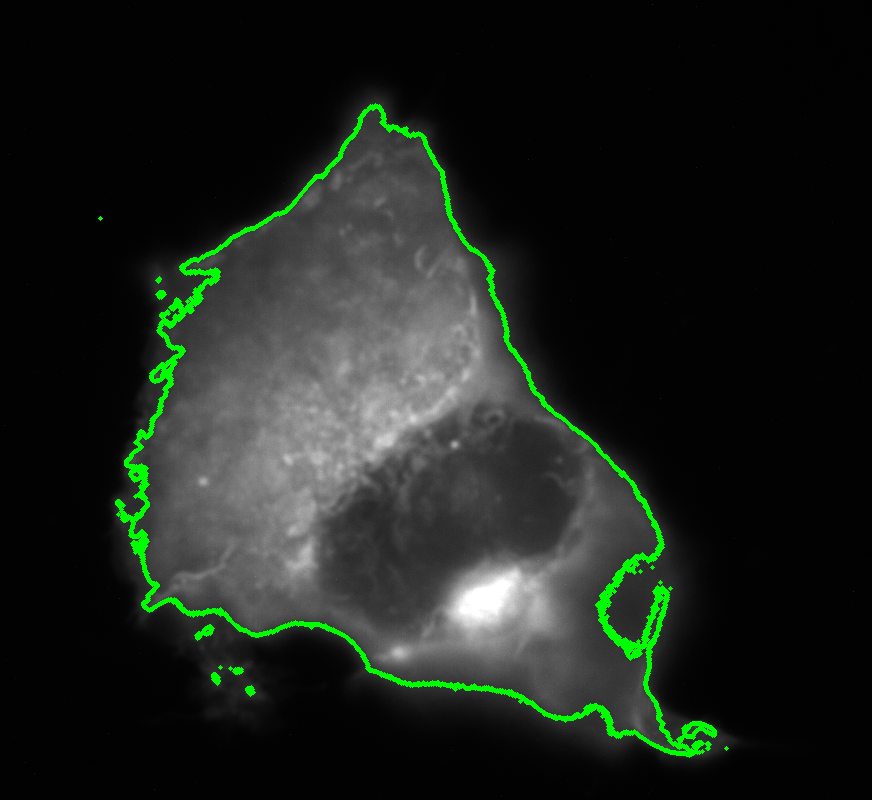

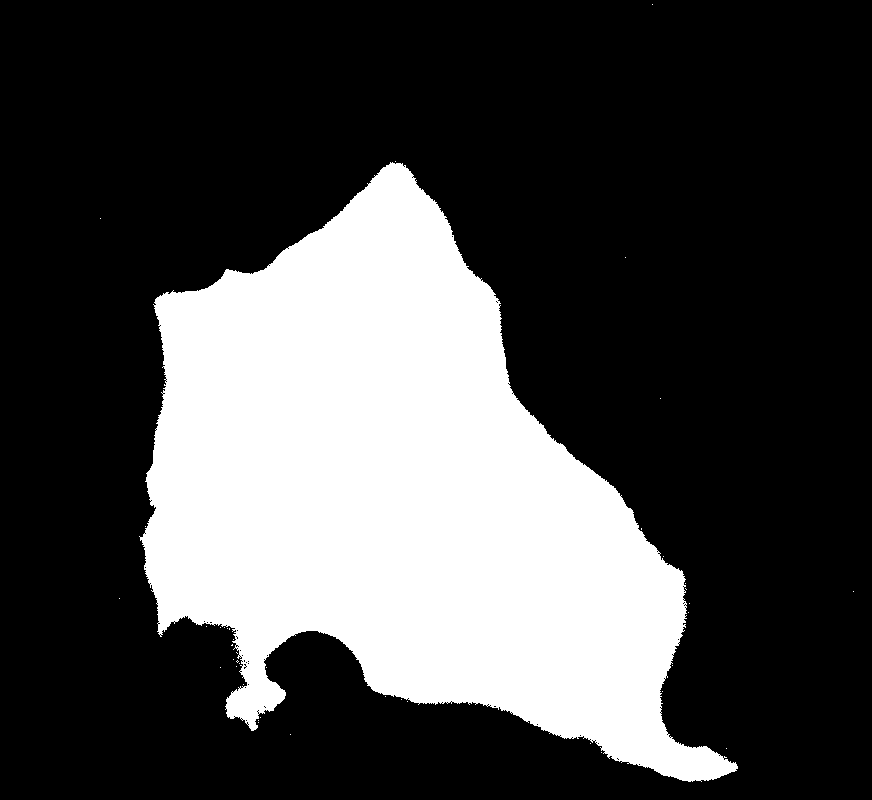

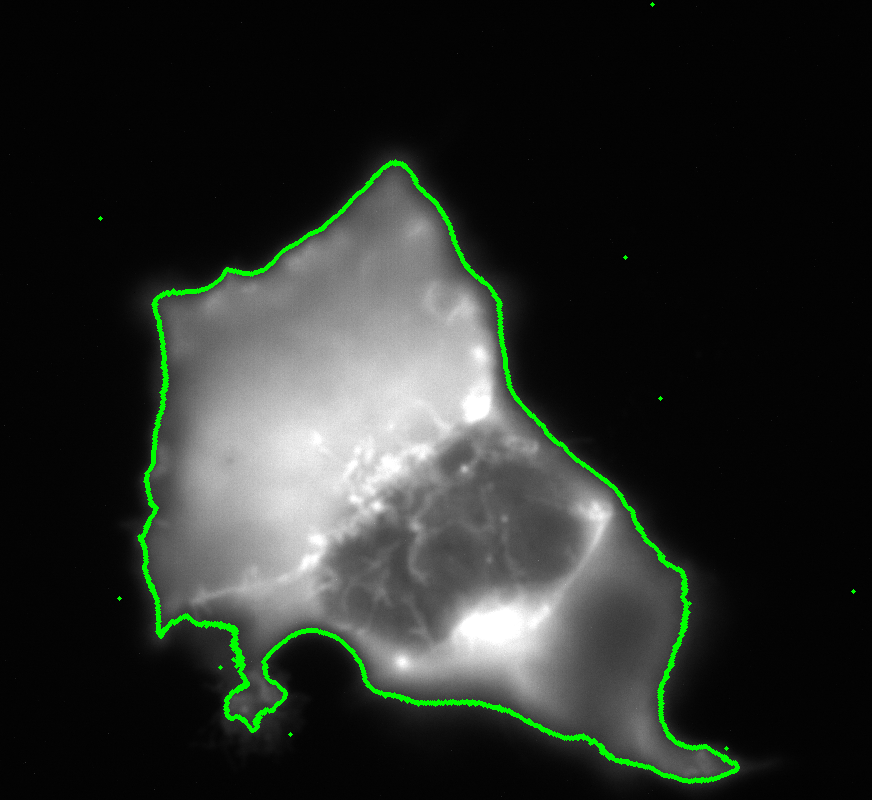

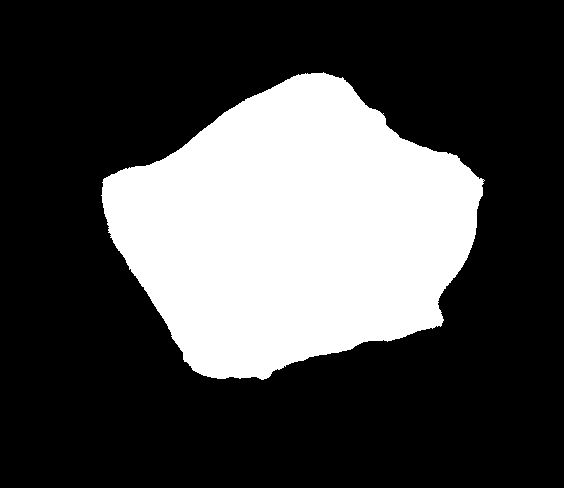

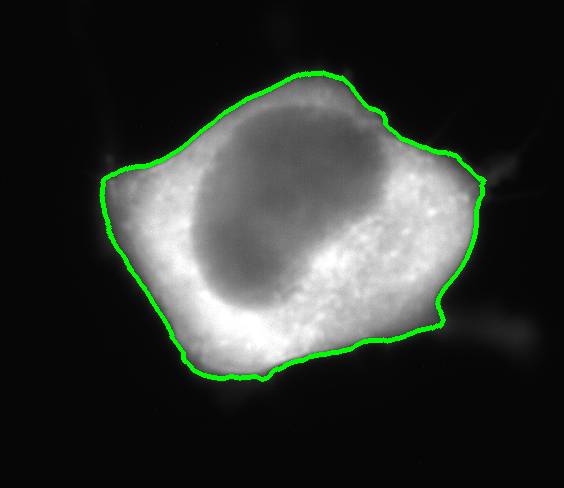

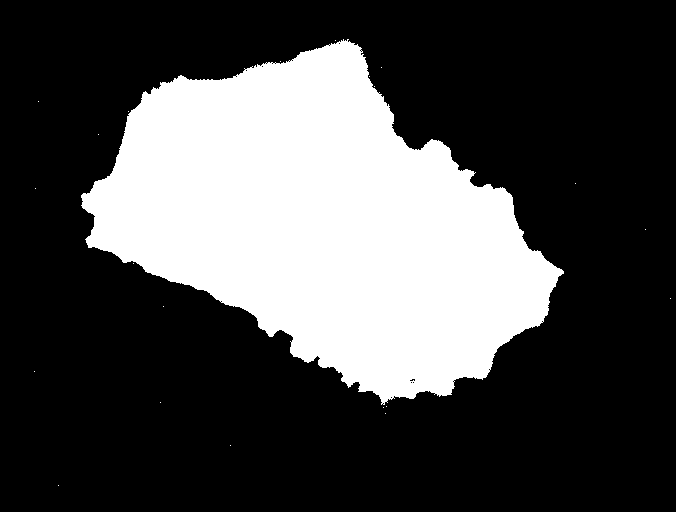

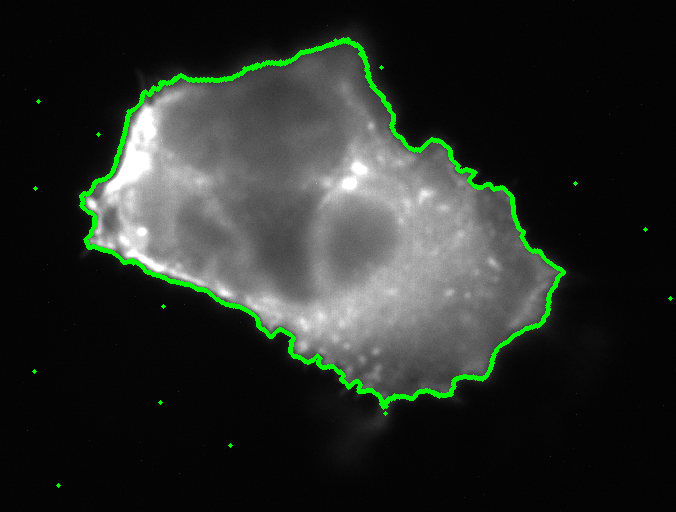

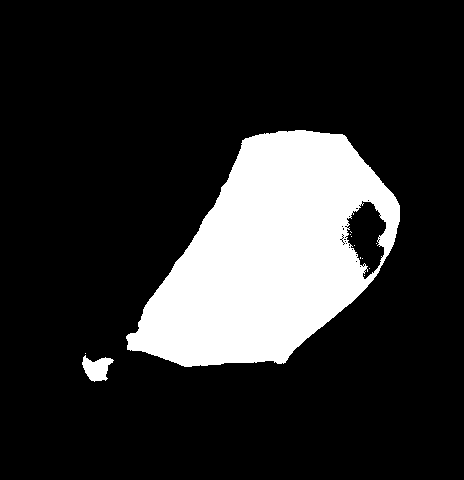

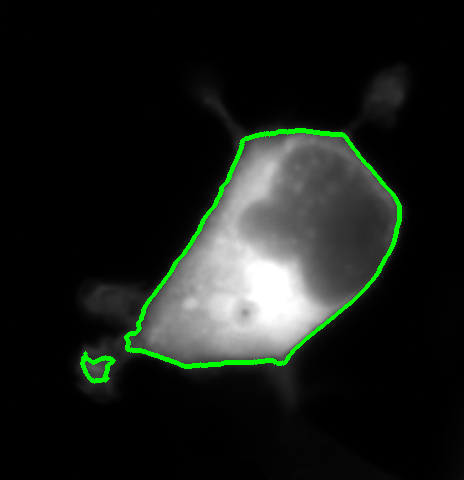

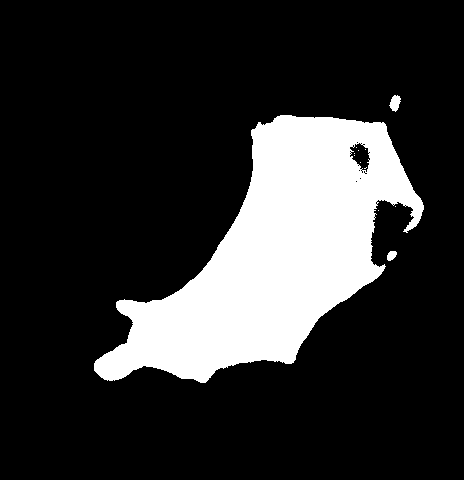

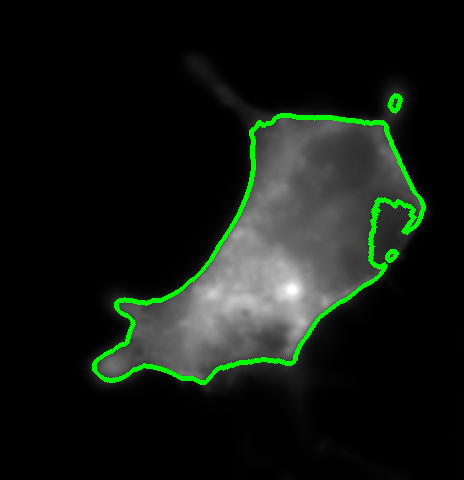

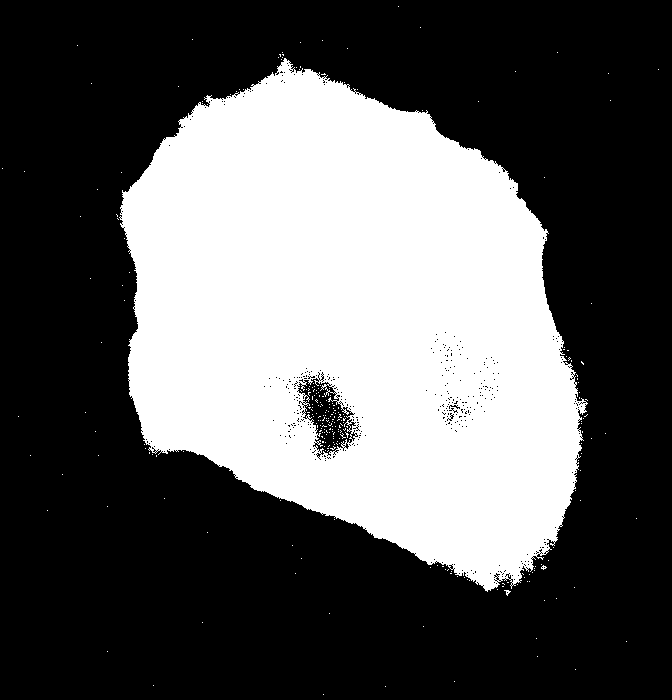

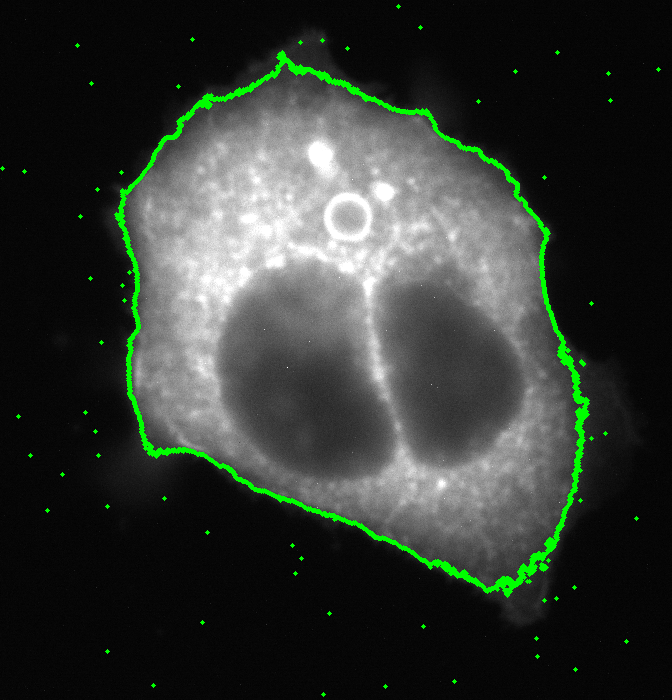

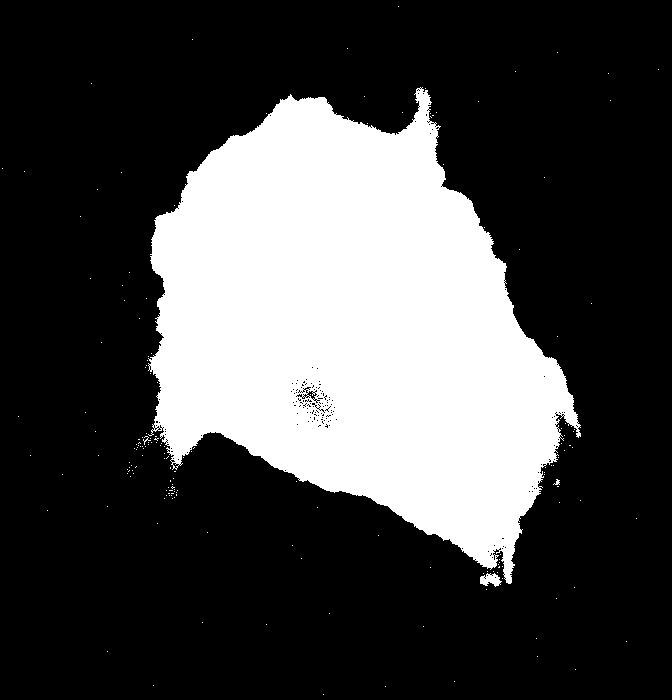

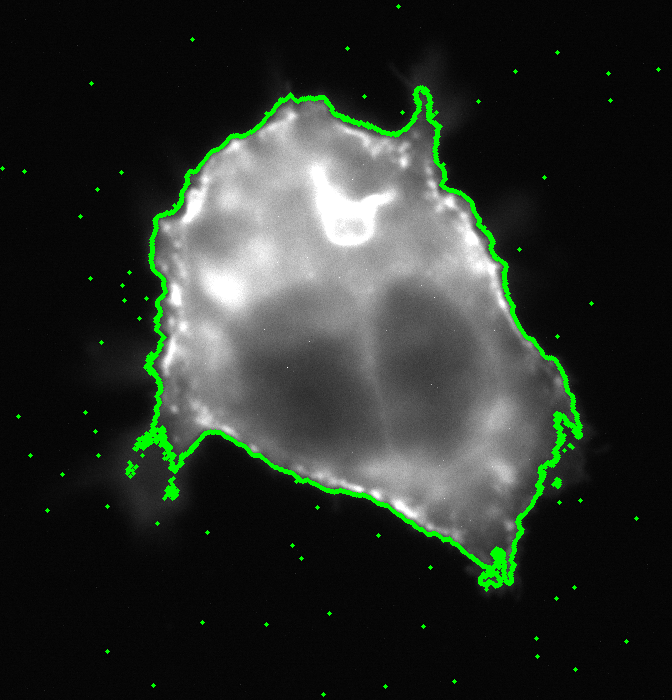

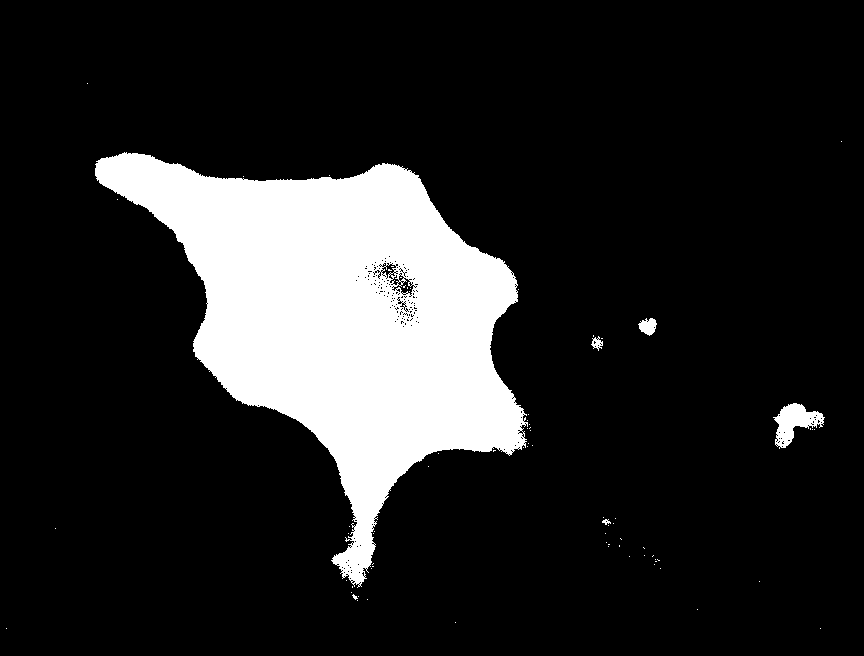

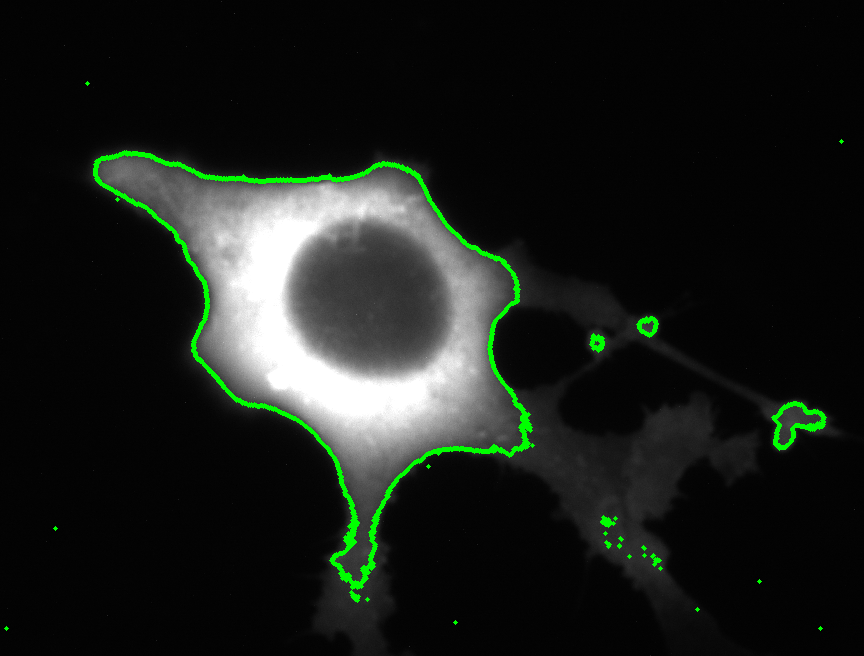

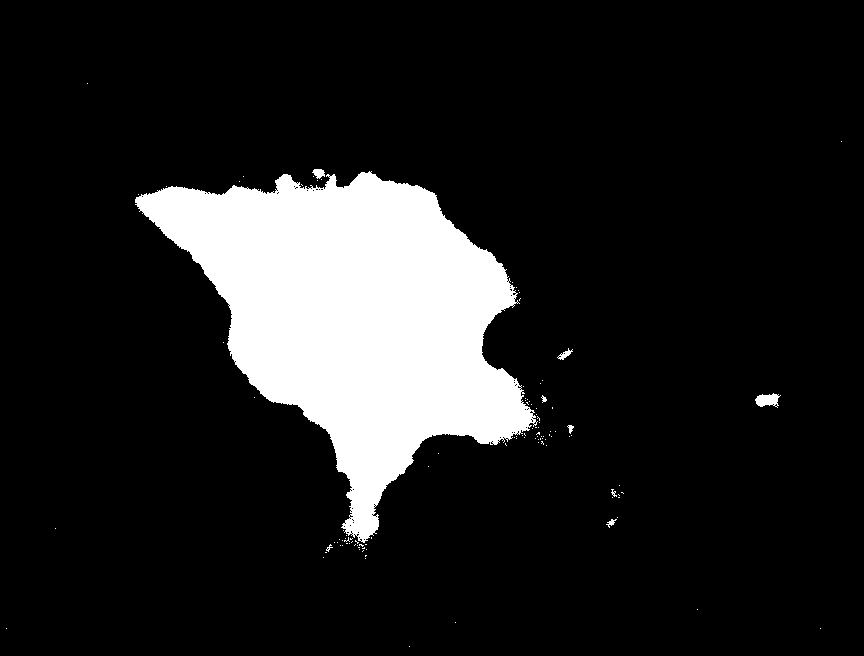

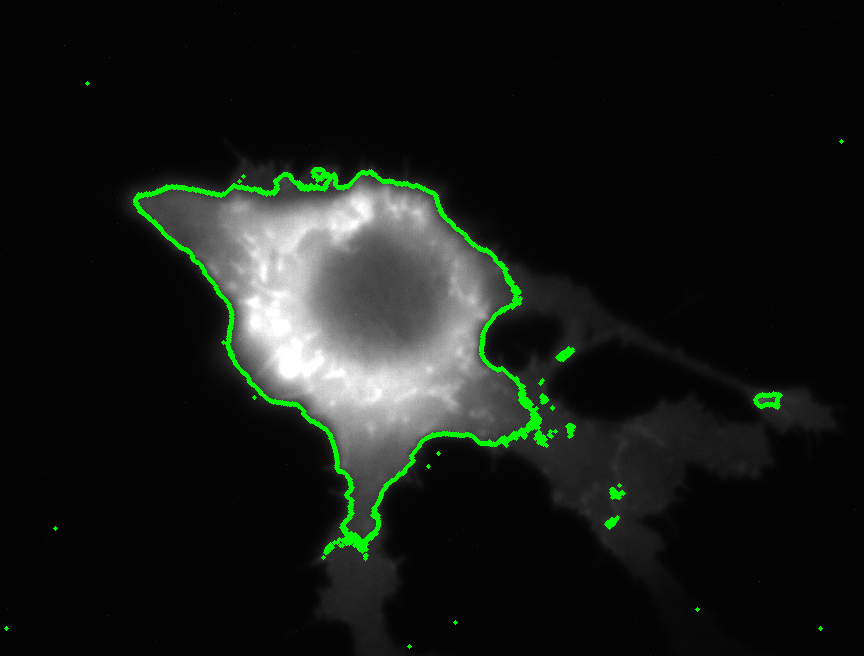

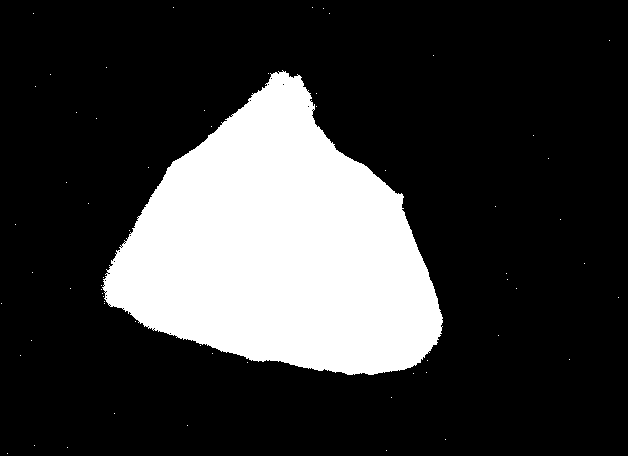

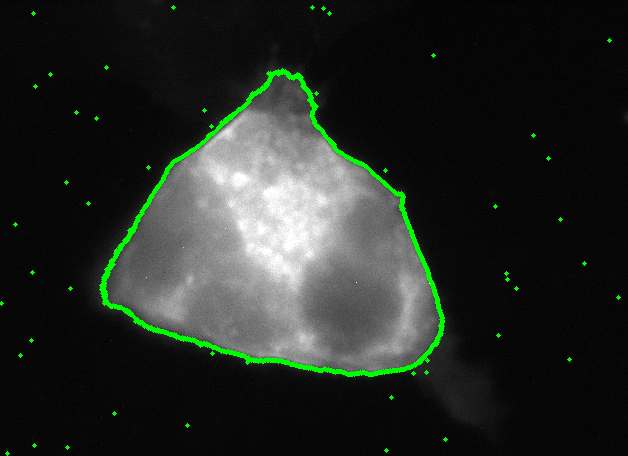

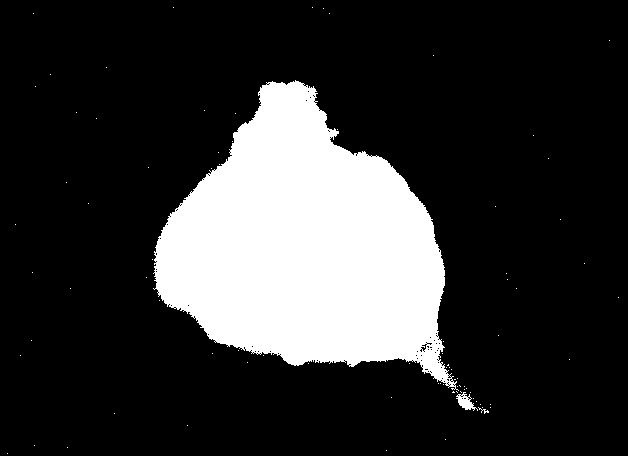

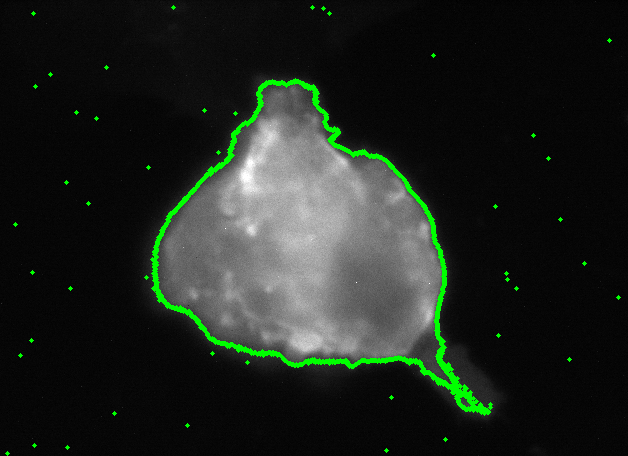

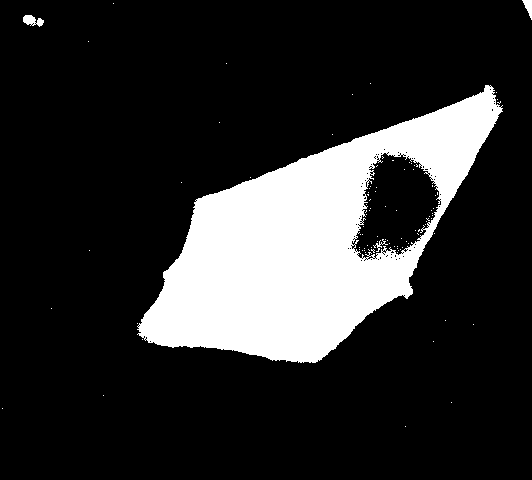

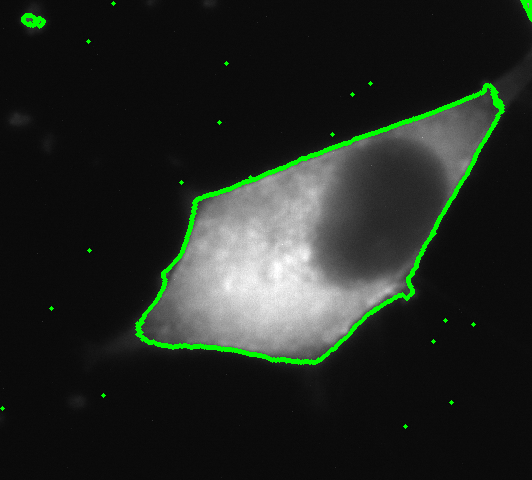

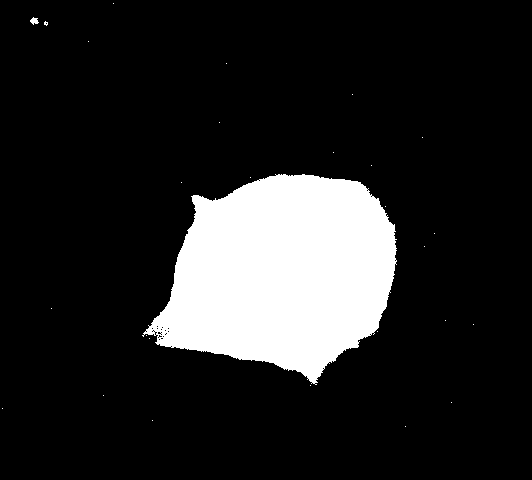

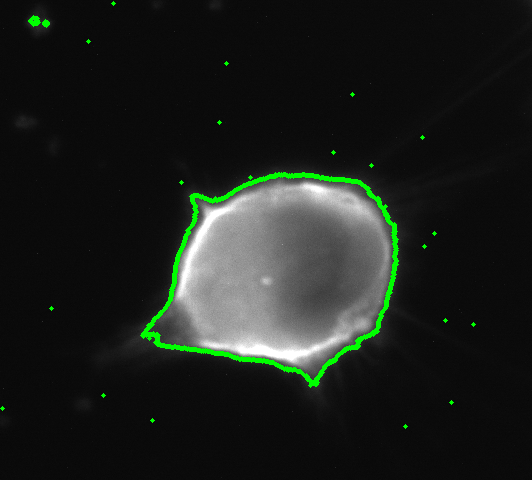

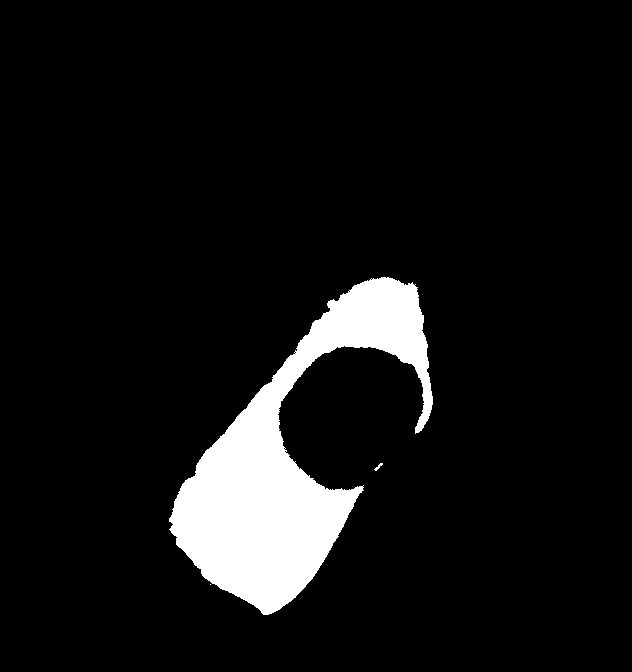

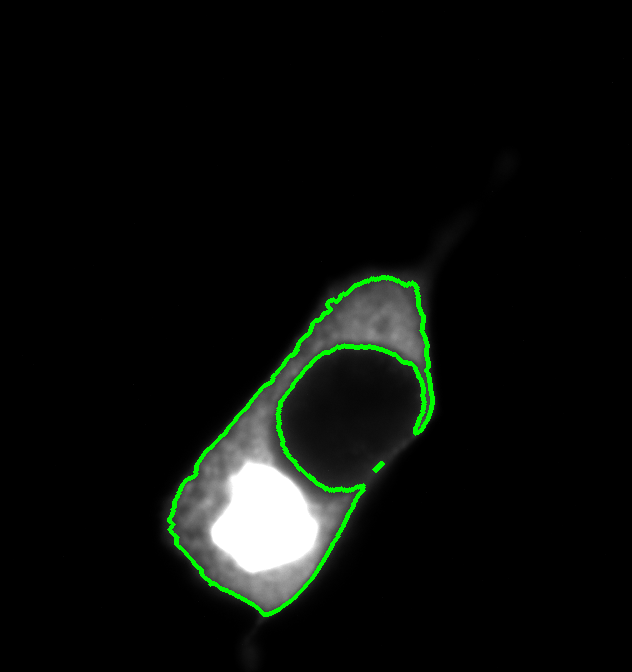

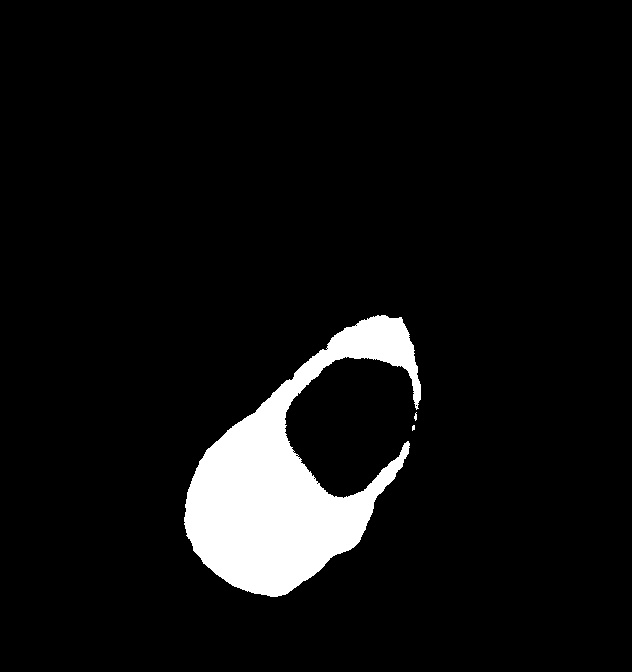

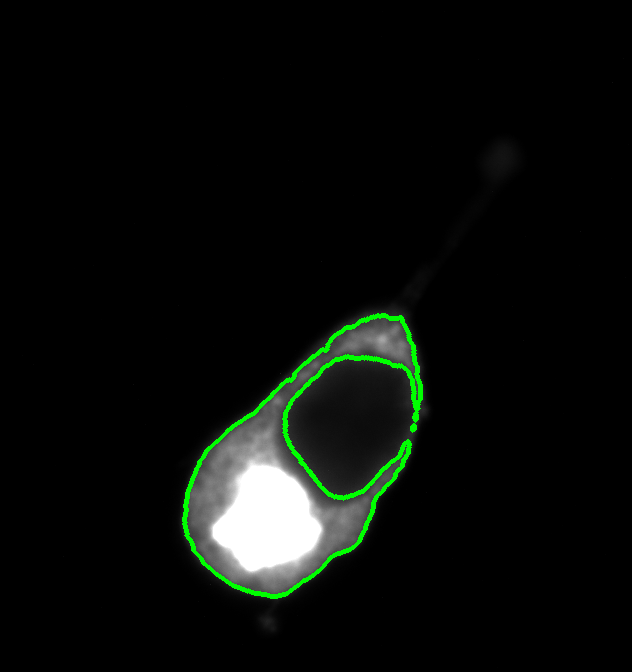

In [ ]:
import cv2
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive', force_remount = True)
from google.colab.patches import cv2_imshow


def contourFinder(fileName, lowerBound):
    imageColor = cv2.imread(fileName, cv2.IMREAD_COLOR)
    image = cv2.imread(fileName, cv2.IMREAD_GRAYSCALE)
    if image is not None:
      ret, thresh = cv2.threshold(image, lowerBound, 255, cv2.THRESH_BINARY)
      contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
      cnt = cv2.drawContours(imageColor, contours, -1, (0, 255, 0), 3)
      cv2_imshow(thresh)
      cv2_imshow(cnt)
      return contours


def areaFinder(contours):
    if contours is not None and len(contours) > 0:
        return cv2.contourArea(contours)


def maxAreaContourFinder(contours):
    areas = []
    if contours is not None and len(contours) > 0:
        for contour in contours:
            areas.append(areaFinder(contour))
        while len(areas) > 0:
            maxIndex = areas.index(max(areas))
            return contours[maxIndex]


def centroidFinder(contours):
    if contours is not None and len(contours) > 0:
        M = cv2.moments(contours)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            return (cX, cY)


def brightnessFinder(fileName, contours):
    image = cv2.imread(fileName, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        kernel = np.ones((9, 9), np.uint8)
        frameDraw = np.zeros(image.shape, np.uint8)
        cont = cv2.fillPoly(frameDraw, [contours], 255)
        locs = np.where(cont == 255)
        pixels = image[locs]
        brightness = np.mean(pixels)

        return brightness


def velocityCalculator(centroid1, centroid2):
    if centroid1 is not None and centroid2 is not None:
        x1, y1 = centroid1
        x2, y2 = centroid2
        d = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        t = 600
        return d / t


def relChangeFinder(val1, val2):
    if val1 is not None and val2 is not None:
        if val1 != 0:
            return abs((val2 - val1) / val1) * 100
        else:
            return val2


def oneTrial(trialName, threshold):
    file0 = trialName + "_0min.tif"
    file10 = trialName + "_10min.tif"
    contours0 = maxAreaContourFinder(contourFinder(file0, threshold))
    contours10 = maxAreaContourFinder(contourFinder(file10, threshold))

    centroid0 = centroidFinder(contours0)
    centroid10 = centroidFinder(contours10)
    velocity = velocityCalculator(centroid0, centroid10)
    areaChange = relChangeFinder(areaFinder(contours0), areaFinder(contours10))
    brightnessChange = relChangeFinder(brightnessFinder(file0, contours0), brightnessFinder(file10, contours10))

    if velocity is None:
        velocity = 0.0
    if areaChange is None:
        areaChange = 0.0
    if brightnessChange is None:
        brightnessChange = 0.0

    return [trialName, velocity, areaChange, brightnessChange]


def allTrials():
    trials = []
    for i in [1, 2]:
        for j in range(1, 6):
            trials.append('/content/drive/MyDrive/S24_HW7_images/type' + str(i) + '_cell' + str(j))
    results = []
    for trial in trials:
        results.append(oneTrial(trial, 50))

    return results


def dataWriter(nestedList):
    indexList = []
    for i in [1, 2]:
        for j in range(1, 6):
            indexList.append('type ' + str(i) + ' cell ' + str(j))
    columnList = ['File Name', 'Velocity', 'Area Change', 'Brightness Change']
    resultsDF = pd.DataFrame(nestedList, index=indexList, columns=columnList)
    with pd.ExcelWriter("dataOutput.xlsx") as writer:
        resultsDF.to_excel(writer, sheet_name="image data")


def main():
    results = allTrials()
    dataWriter(results)

if __name__ == "__main__":
    main()

In [ ]:
import unittest

class TestVelocity(unittest.TestCase):
    def test_velocityCalculator_type(self):
        centroid1 = (10.0,20.0)
        centroid2 = (30.0,40.0)

        centroid3 = (20.0,35.0)
        centroid4 = (40.0,60.0)

        velocityTest1 = velocityCalculator(centroid1,centroid2)
        velocityTest2 = velocityCalculator(centroid3,centroid4)

        self.assertTrue(type(velocityTest1 == float))
        self.assertTrue(type(velocityTest2 == float))

    def test_velocityCalculator_value(self):
        centroid1 = (10.0,20.0)
        centroid2 = (30.0,40.0)

        centroid3 = (20.0,35.0)
        centroid4 = (40.0,60.0)

        velocityTest1 = velocityCalculator(centroid1,centroid2)
        velocityTest2 = velocityCalculator(centroid3,centroid4)

        self.assertTrue(velocityTest1 == 0.04714045207910317)
        self.assertTrue(velocityTest2 == 0.053359368645273735)

class TestChangeFinder(unittest.TestCase):
    def test_relChangeFinder_type(self):
        val1 = 10
        val2 = 15

        val3 = 20
        val4 = 15

        change1 = relChangeFinder(val1,val2)
        change2 = relChangeFinder(val3,val4)

        self.assertTrue(type(change1) == float and change1 > 0)
        self.assertTrue(type(change2) == float and change2 > 0)

    def test_relChangeFinder_value(self):
        val1 = 10
        val2 = 15

        val3 = 20
        val4 = 15

        change1 = relChangeFinder(val1,val2)
        change2 = relChangeFinder(val3,val4)

        self.assertTrue(change1 == 50.0)
        self.assertTrue(change2 == 25.0)

unittest.main(argv=[''], verbosity=2, exit=False)

test_relChangeFinder_type (__main__.TestChangeFinder) ... ok
test_relChangeFinder_value (__main__.TestChangeFinder) ... ok
test_velocityCalculator_type (__main__.TestVelocity) ... ok
test_velocityCalculator_value (__main__.TestVelocity) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.015s

OK
